#### loading library

In [1]:
import cv2
import yaml
import os
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch.nn import functional as F

import onnx
import onnxruntime
from onnxruntime.quantization import QuantType
from onnxruntime.quantization.quantize import quantize_dynamic

#### Conversion & Model loading code

In [2]:
def model_conversion(myModel, dummy_inputs, onnx_model_pth, onnx_quant_pth):

    # onnx conversion
    torch.onnx.export(
        model = myModel,                            # 실행될 모델
        args = tuple(dummy_inputs.values()),        # 모델 입력값(tuple or 여러 입력값)
        f = onnx_model_pth,                     # 모델 저장 경로
        export_params=True,                 # 모델 파일 안에 학습된 모델 가중치 저장 여부
        opset_version=13,                   # 모델 변환할 때 사용할 onnx 버전
        do_constant_folding = True,         # 최적화시 상수폴딩 사용할지 여부
        input_names=list(dummy_inputs.keys()),
        output_names    =   ["output"],
        dynamic_axes    =   {
            'input'     : {0 : 'batch_size'},    # 가변적인 길이를 가진 차원
            'output'    : {0 : 'batch_size'}
        }
    ) 

    # model quantization
    quantize_dynamic(
        model_input     =   onnx_model_pth,
        model_output    =   onnx_quant_pth,
        per_channel     =   False,
        reduce_range    =   False,
        weight_type     =   QuantType.QUInt8,
    )

import transformer

def load_model_for_inference(pretraine_weight):

    # define model & loading pretrained weight
    net = transformer.TransformerNetwork().cuda()
    net.load_state_dict(torch.load(pretraine_weight))
    net.eval()
    print('모델 로딩 완')  
    return net

In [19]:
# onnx 모델 저장 경로
os.makedirs('./onnx_models/', exist_ok=True)
device    = torch.device('cuda')
dummy_inputs = {
    "input" : torch.as_tensor(np.ones([1, 3, 1024, 1024]), dtype = torch.float32).to(device)
}
# model 변환
projectName = 'FastNeuralStyleTransfer'
checkpointName = 'bayanihan'
onnx_model_path = f'./onnx_models/{projectName}-{checkpointName}.onnx'
onnx_model_quantized_path = f'./onnx_models/{projectName}-{checkpointName}_quant.onnx'


# 1. model loading
model = load_model_for_inference(f'./transforms/{checkpointName}.pth')
# 2. model conversion(onnx & onnx quant)
model_conversion(model, dummy_inputs, onnx_model_path, onnx_model_quantized_path)

모델 로딩 완


---

## ONNX-Runtime Test

In [7]:
from utils import *
from torch.autograd import Variable
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor
# prepare input
image_tensor = Image.open('./demo.jpg')
image_tensor = image_tensor.resize((1024, 1024))
image_tensor = pil_to_tensor(image_tensor).type(torch.float32).cuda()
image_tensor = image_tensor.unsqueeze(0)
image_embedding = image_tensor.detach().cpu().numpy()
image_embedding.shape

(1, 3, 1024, 1024)

In [16]:
style = 'tokyo_ghoul'
# loading
ort_session = onnxruntime.InferenceSession(f'./onnx_models/FastNeuralStyleTransfer-{style}_quant.onnx', providers=['AzureExecutionProvider'])
# test running
ort_inputs  = {'input': image_embedding}
#print(ort_inputs  = {'input' : image_embedding})
ort_outputs = ort_session.run(None, ort_inputs)
ort_outputs[0].shape

(1, 1024, 1024, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True

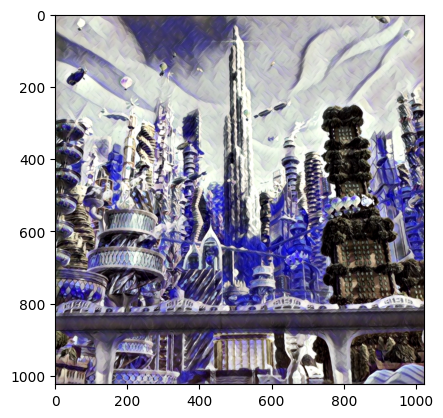

In [17]:
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from torchvision.utils import save_image
out = ort_outputs[0][0]

plt.imshow(out)
cv2.imwrite(f'./result_{style}.png', out.astype(np.float32))